In [1]:
%matplotlib inline


Doc2Vec Model
=============

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
import os
import gensim
from sklearn import metrics
import numpy as np
import seaborn as sns; sns.set()
from matplotlib import pyplot
# Set file names for train and test data
train_file = os.path.join('data/all.txt')

Define a Function to Read and Preprocess Text
---------------------------------------------

Below, we define a function to:

- open the train/test file (with latin encoding)
- read the file line-by-line
- pre-process each line (tokenize text into individual words, remove punctuation, set to lowercase, etc)

The file we're reading is a **corpus**.
Each line of the file is a **document**.

.. Important::
  To train the model, we'll need to associate a tag/number with each document
  of the training corpus. In our case, the tag is simply the zero-based line
  number.




In [4]:
import smart_open

def read_corpus(fname, tokens_only=False):
    with smart_open.open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(train_file))

Training the Model
------------------

Now, we'll instantiate a Doc2Vec model with a vector size with 50 dimensions and
iterating over the training corpus 40 times. We set the minimum word count to
2 in order to discard words with very few occurrences. (Without a variety of
representative examples, retaining such infrequent words can often make a
model worse!) Typical iteration counts in the published `Paragraph Vector paper <https://cs.stanford.edu/~quocle/paragraph_vector.pdf>`__
results, using 10s-of-thousands to millions of docs, are 10-20. More
iterations take more time and eventually reach a point of diminishing
returns.

However, this is a very very small dataset (300 documents) with shortish
documents (a few hundred words). Adding training passes can sometimes help
with such small datasets.




In [5]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

2019-11-22 10:23:00,170 : WARNING : consider setting layer size to a multiple of 4 for greater performance


Build a vocabulary



In [6]:
model.build_vocab(train_corpus)

2019-11-22 10:23:00,193 : INFO : collecting all words and their counts
2019-11-22 10:23:00,193 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2019-11-22 10:23:00,282 : INFO : collected 22668 word types and 37 unique tags from a corpus of 37 examples and 777116 words
2019-11-22 10:23:00,283 : INFO : Loading a fresh vocabulary
2019-11-22 10:23:00,314 : INFO : effective_min_count=2 retains 14306 unique words (63% of original 22668, drops 8362)
2019-11-22 10:23:00,315 : INFO : effective_min_count=2 leaves 768754 word corpus (98% of original 777116, drops 8362)
2019-11-22 10:23:00,346 : INFO : deleting the raw counts dictionary of 22668 items
2019-11-22 10:23:00,347 : INFO : sample=0.001 downsamples 62 most-common words
2019-11-22 10:23:00,347 : INFO : downsampling leaves estimated 581967 word corpus (75.7% of prior 768754)
2019-11-22 10:23:00,372 : INFO : estimated required memory for 14306 words and 50 dimensions: 12882800 bytes
2019-11-22 10:23:00,372 : I

Essentially, the vocabulary is a dictionary (accessible via
``model.wv.vocab``\ ) of all of the unique words extracted from the training
corpus along with the count (e.g., ``model.wv.vocab['penalty'].count`` for
counts for the word ``penalty``\ ).




Next, train the model on the corpus.
If the BLAS library is being used, this should take no more than 3 seconds.
If the BLAS library is not being used, this should take no more than 2
minutes, so use BLAS if you value your time.




In [7]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

2019-11-22 10:23:02,281 : INFO : training model with 3 workers on 14306 vocabulary and 50 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2019-11-22 10:23:02,459 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-22 10:23:02,466 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-22 10:23:02,470 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-22 10:23:02,471 : INFO : EPOCH - 1 : training on 777116 raw words (370037 effective words) took 0.2s, 1989058 effective words/s
2019-11-22 10:23:02,652 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-22 10:23:02,655 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-22 10:23:02,662 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-22 10:23:02,663 : INFO : EPOCH - 2 : training on 777116 raw words (370037 effective words) took 0.2s, 1952313 effective words/s
2019-11-22 10:23:02,840 : INFO : 

2019-11-22 10:23:06,313 : INFO : EPOCH - 20 : training on 777116 raw words (370037 effective words) took 0.2s, 1951724 effective words/s
2019-11-22 10:23:06,514 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-22 10:23:06,520 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-22 10:23:06,523 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-22 10:23:06,523 : INFO : EPOCH - 21 : training on 777116 raw words (370037 effective words) took 0.2s, 1784553 effective words/s
2019-11-22 10:23:06,725 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-22 10:23:06,729 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-22 10:23:06,738 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-22 10:23:06,739 : INFO : EPOCH - 22 : training on 777116 raw words (370037 effective words) took 0.2s, 1731525 effective words/s
2019-11-22 10:23:06,911 : INFO : worker thr

2019-11-22 10:23:10,146 : INFO : EPOCH - 40 : training on 777116 raw words (370037 effective words) took 0.2s, 1978686 effective words/s
2019-11-22 10:23:10,146 : INFO : training on a 31084640 raw words (14801480 effective words) took 7.9s, 1881972 effective words/s


Now, we can use the trained model to infer a vector for any piece of text
by passing a list of words to the ``model.infer_vector`` function. This
vector can then be compared with other vectors via cosine similarity.




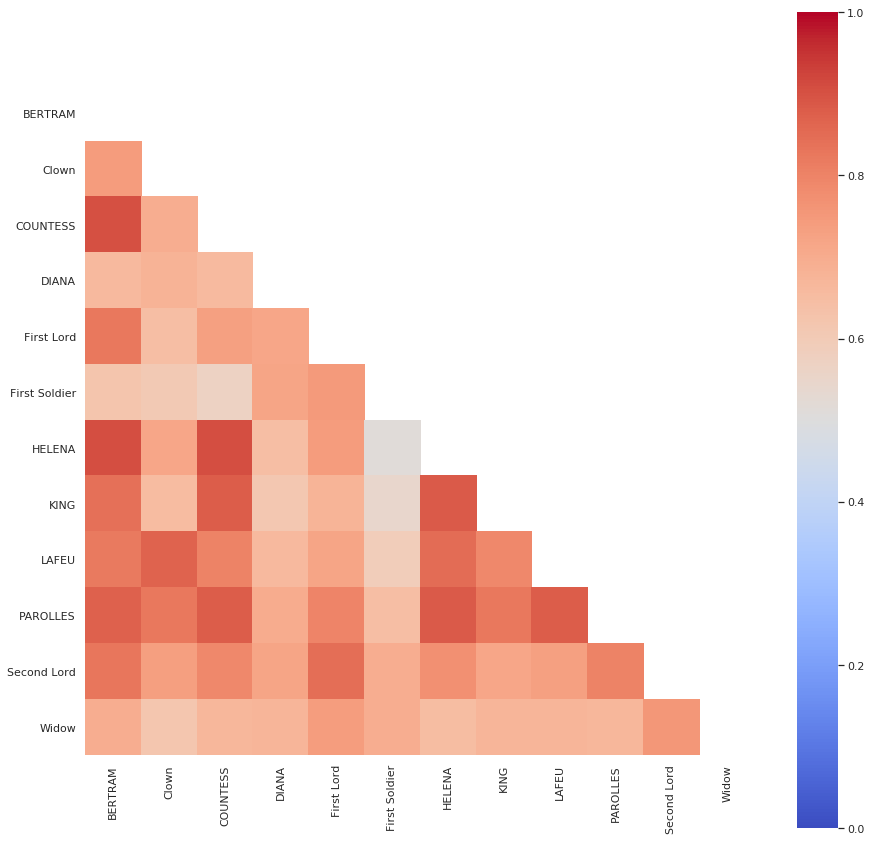

In [12]:
with open('data/All\'s Well That Ends Well/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/All\'s Well That Ends Well/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

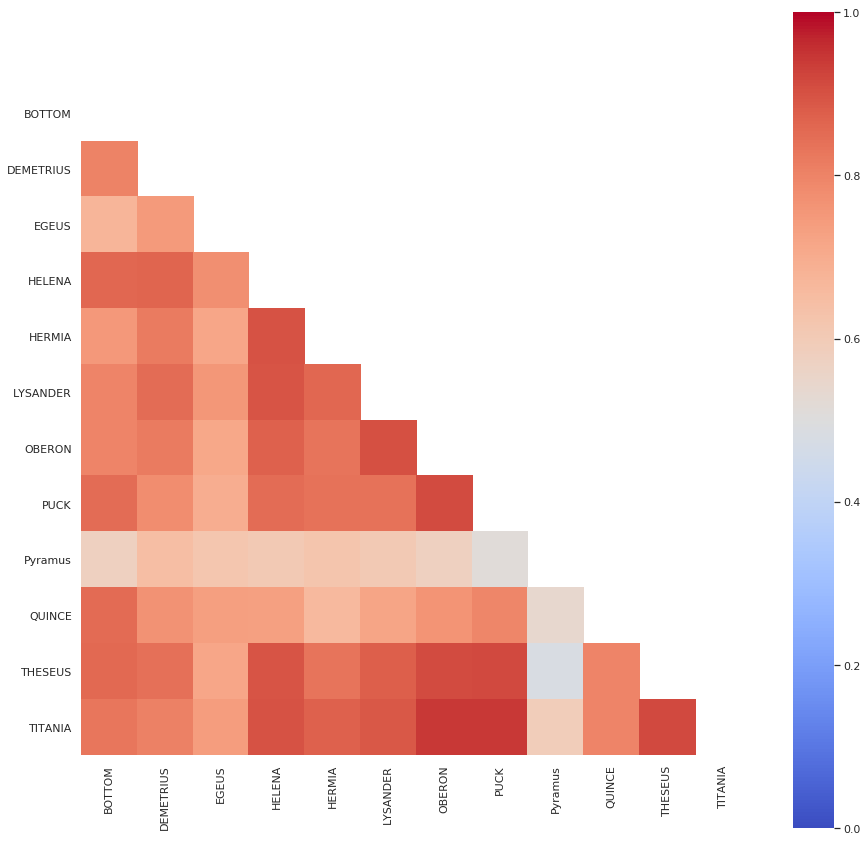

In [13]:
with open('data/A Midsummer Night\'s Dream/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/A Midsummer Night\'s Dream/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

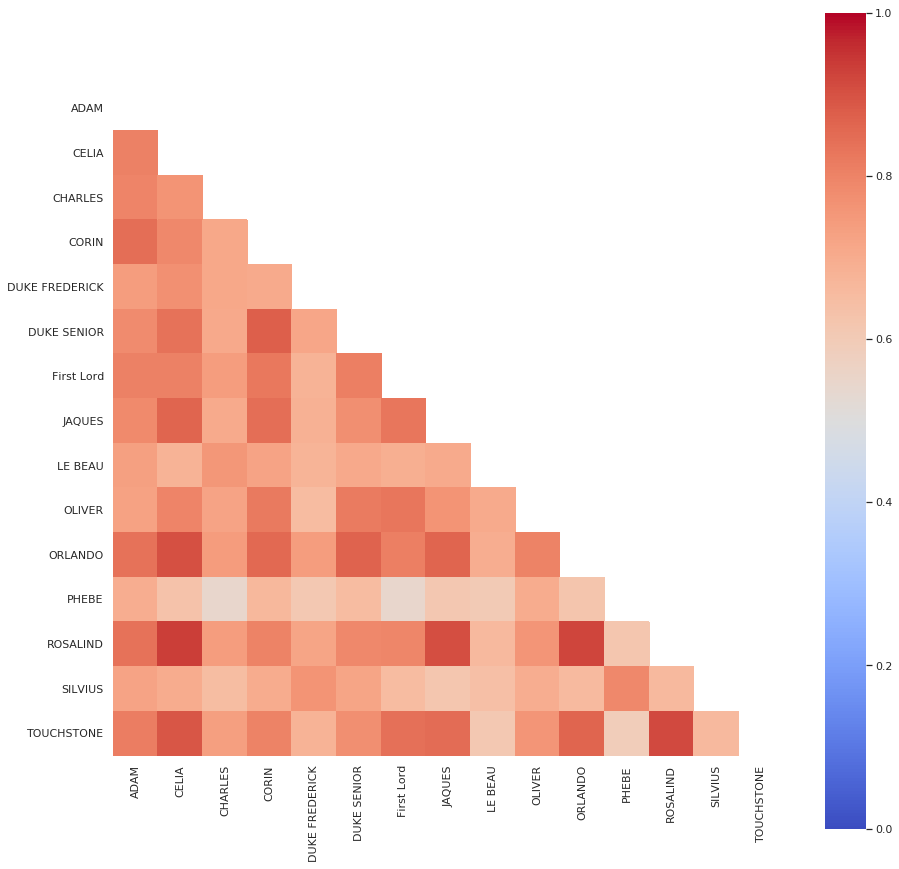

In [14]:
with open('data/As You Like It/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/As You Like It/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

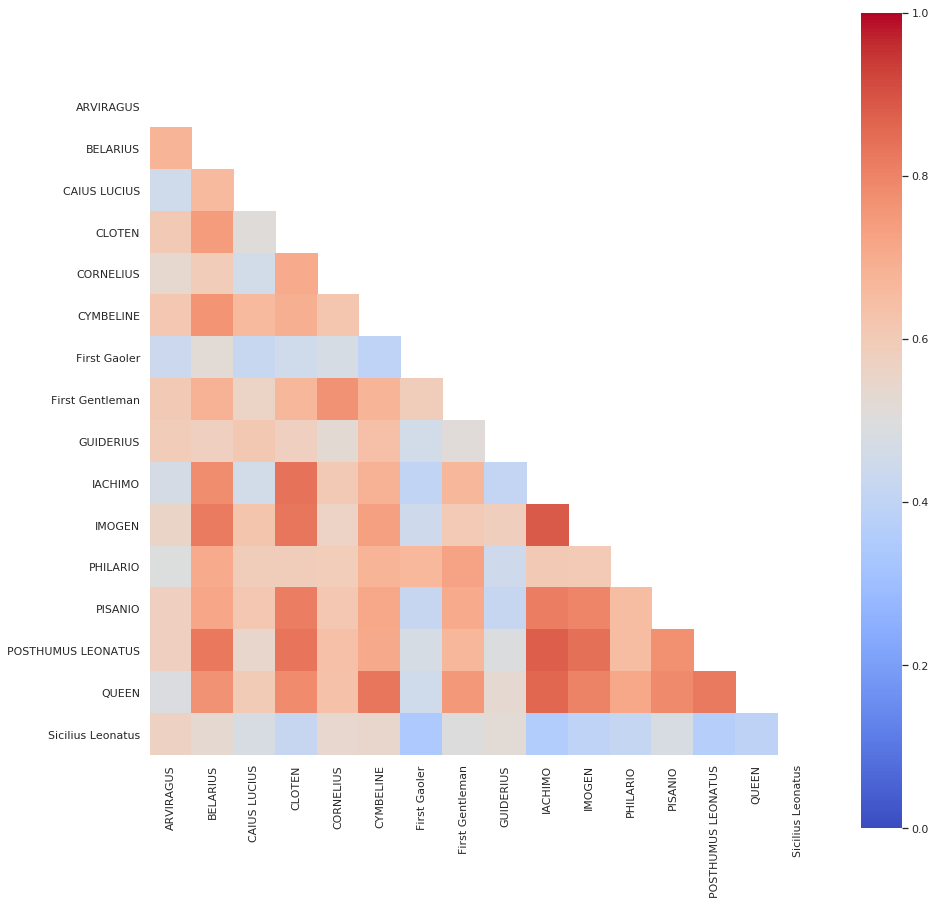

In [15]:
with open('data/Cymbeline/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/Cymbeline/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")        
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

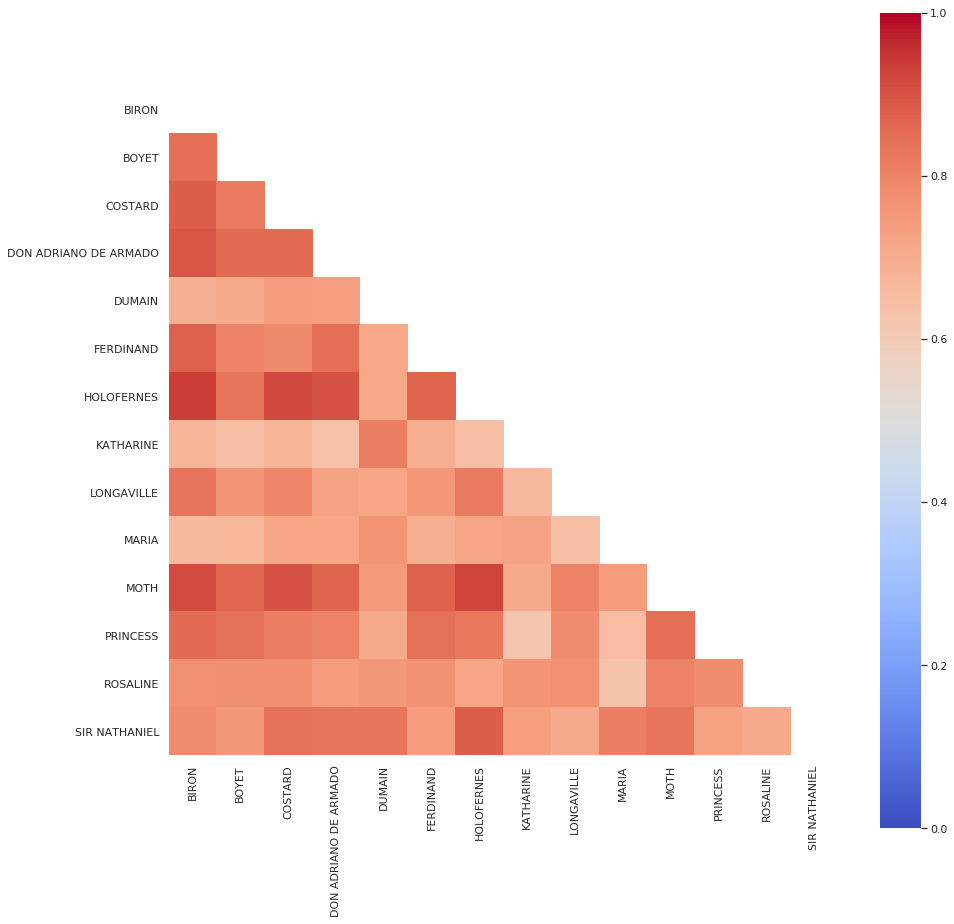

In [16]:
with open('data/Love\'s Labour\'s Lost/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/Love\'s Labour\'s Lost/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")          
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

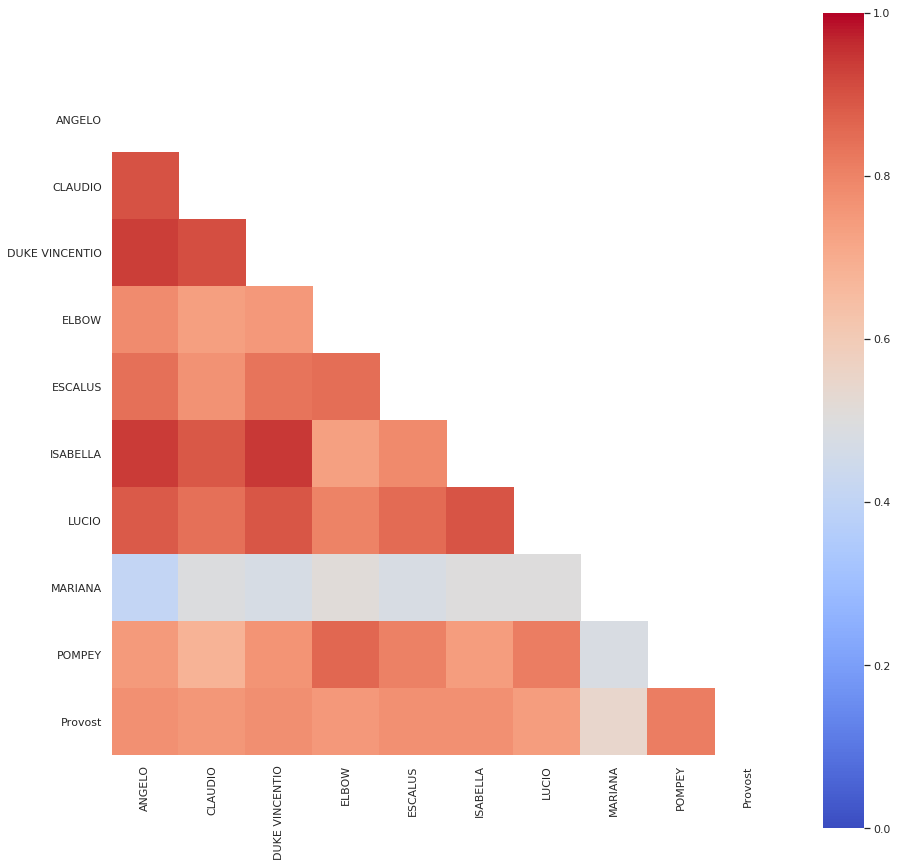

In [17]:
with open('data/Measure for Measure/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/Measure for Measure/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 
        
mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

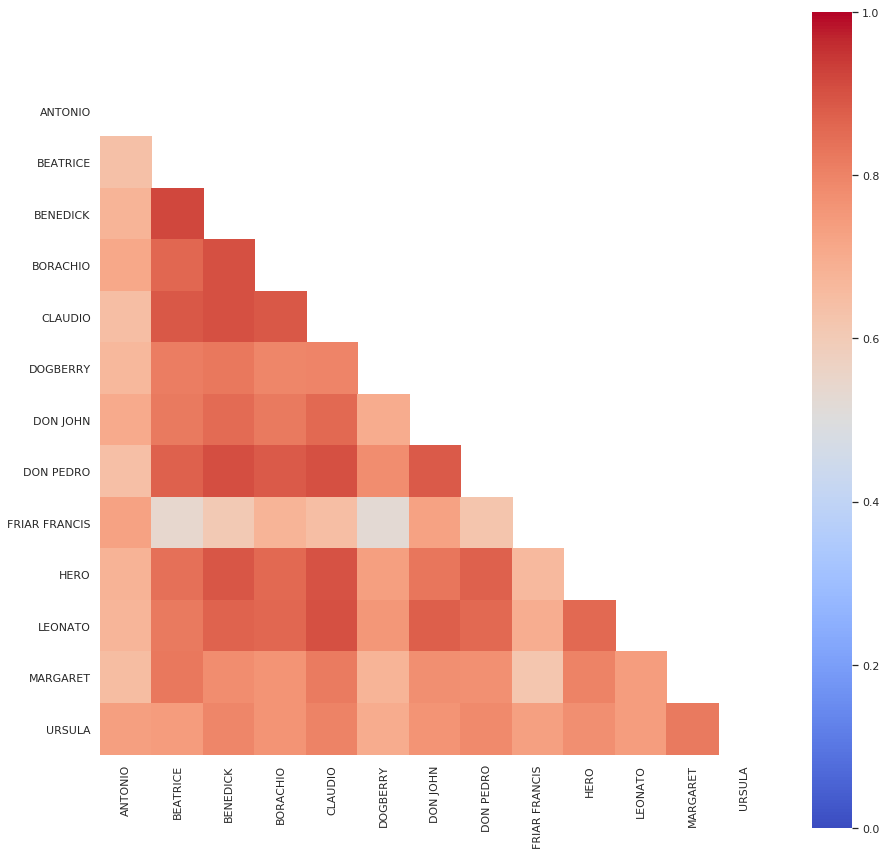

In [18]:
with open('data/Much Ado about Nothing/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/Much Ado about Nothing/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")   
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

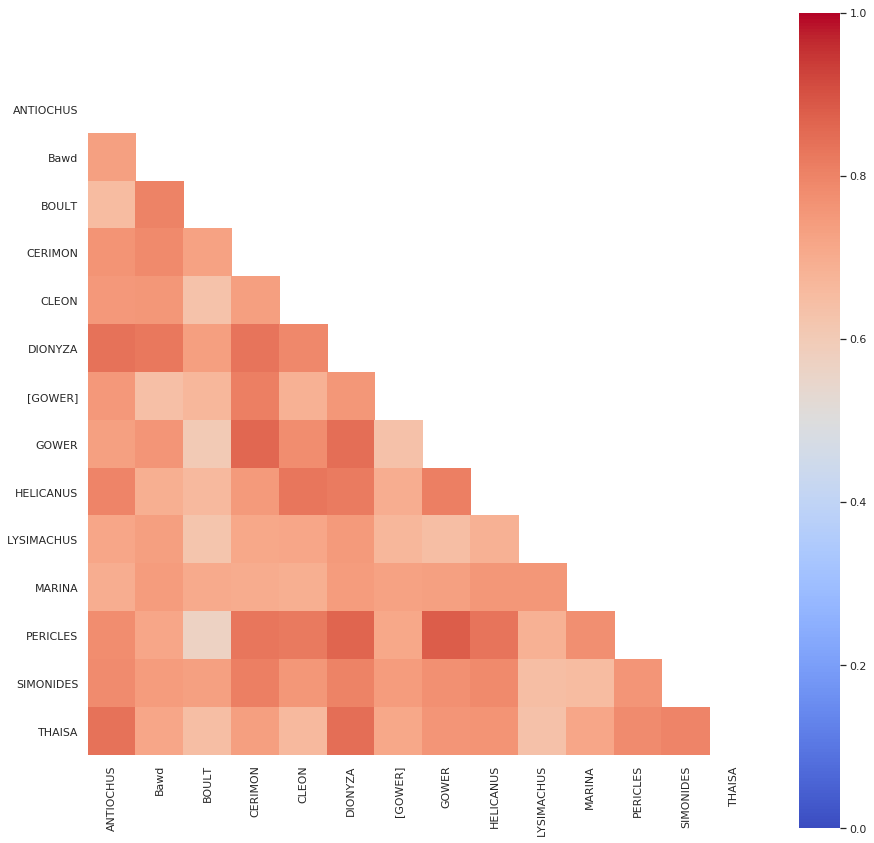

In [19]:
with open('data/Pericles, Prince of Tyre/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/Pericles, Prince of Tyre/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")   
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

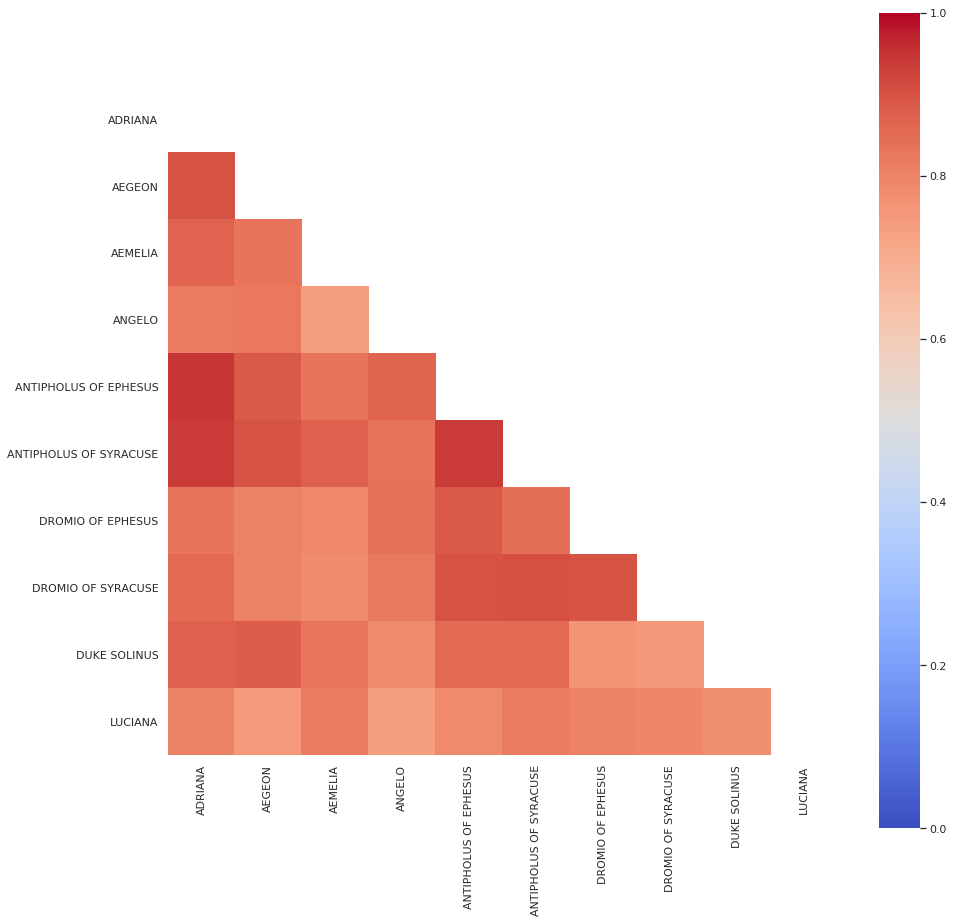

In [20]:
with open('data/The Comedy of Errors/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Comedy of Errors/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")   
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

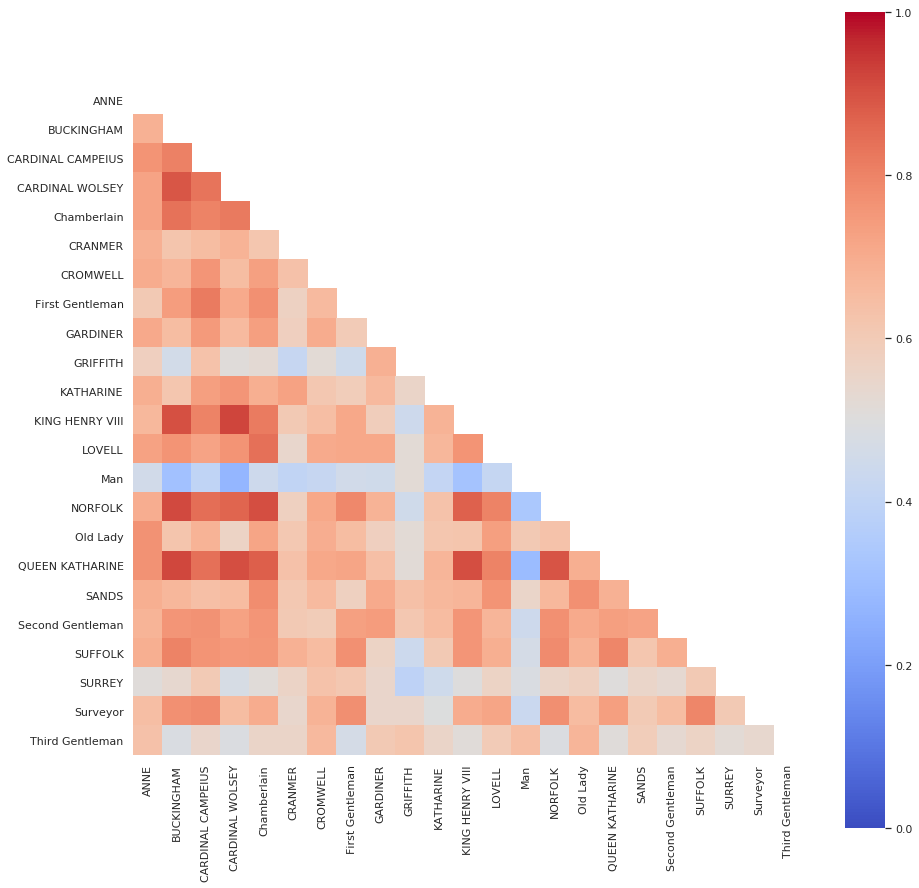

In [21]:
with open('data/The Famous History of the Life of Henry the Eighth/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Famous History of the Life of Henry the Eighth/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log") 
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

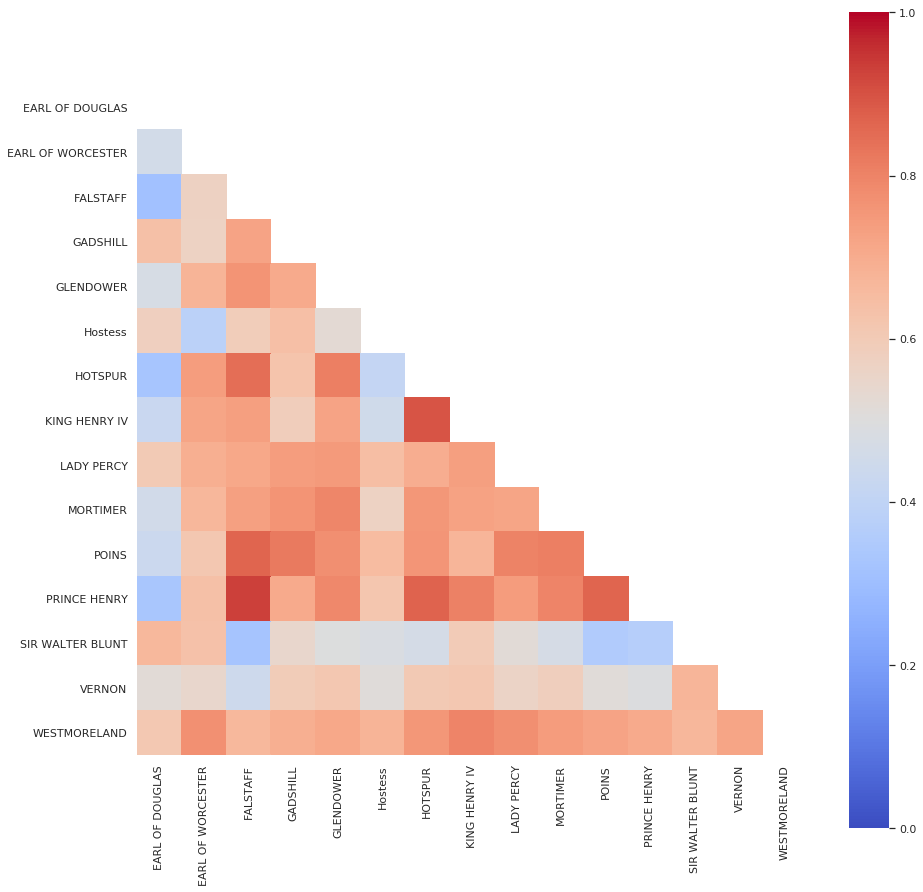

In [22]:
with open('data/The First Part of Henry the Fourth/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The First Part of Henry the Fourth/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

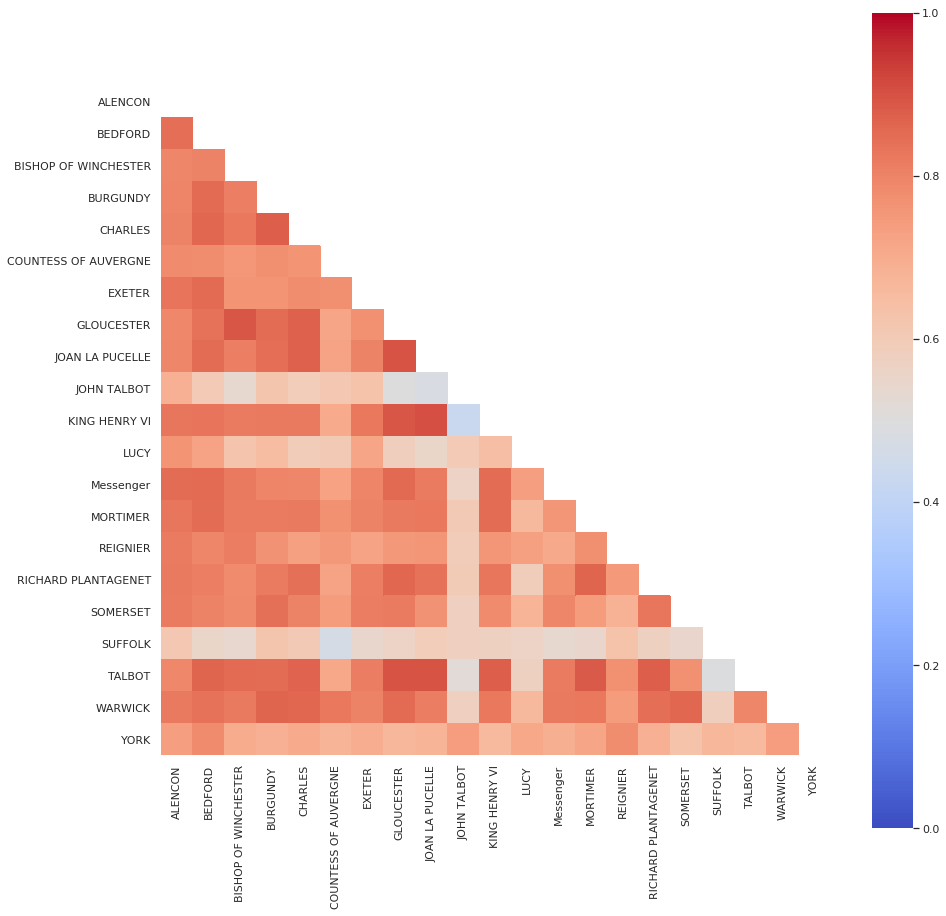

In [23]:
with open('data/The First Part of Henry the Sixth/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The First Part of Henry the Sixth/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

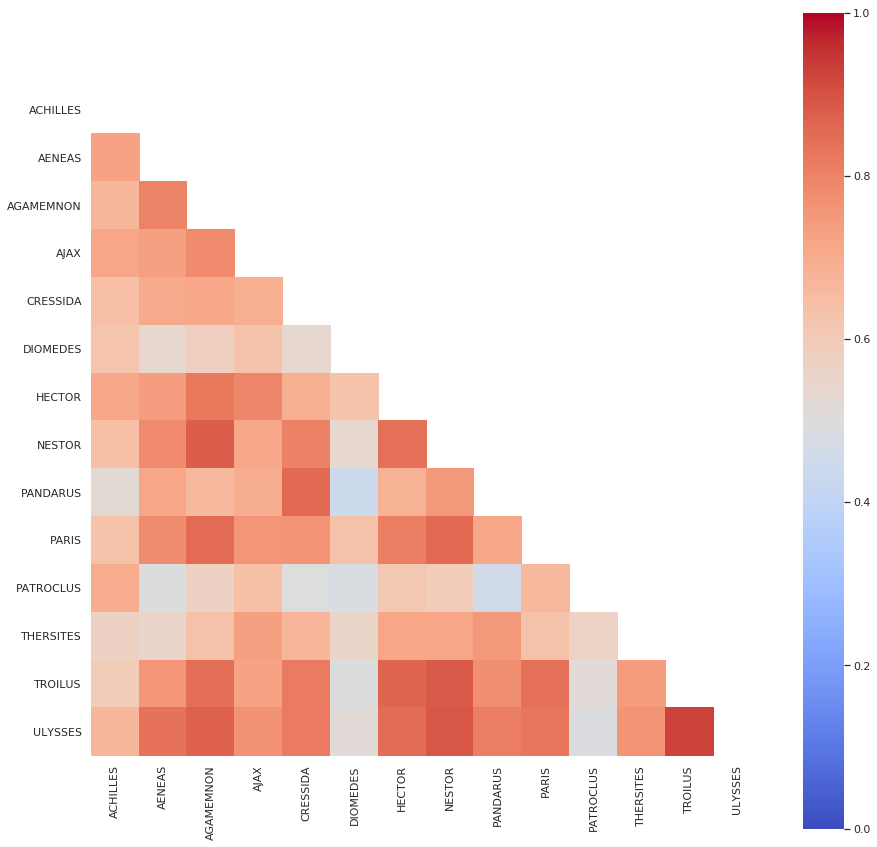

In [24]:
with open('data/The History of Troilus and Cressida/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The History of Troilus and Cressida/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

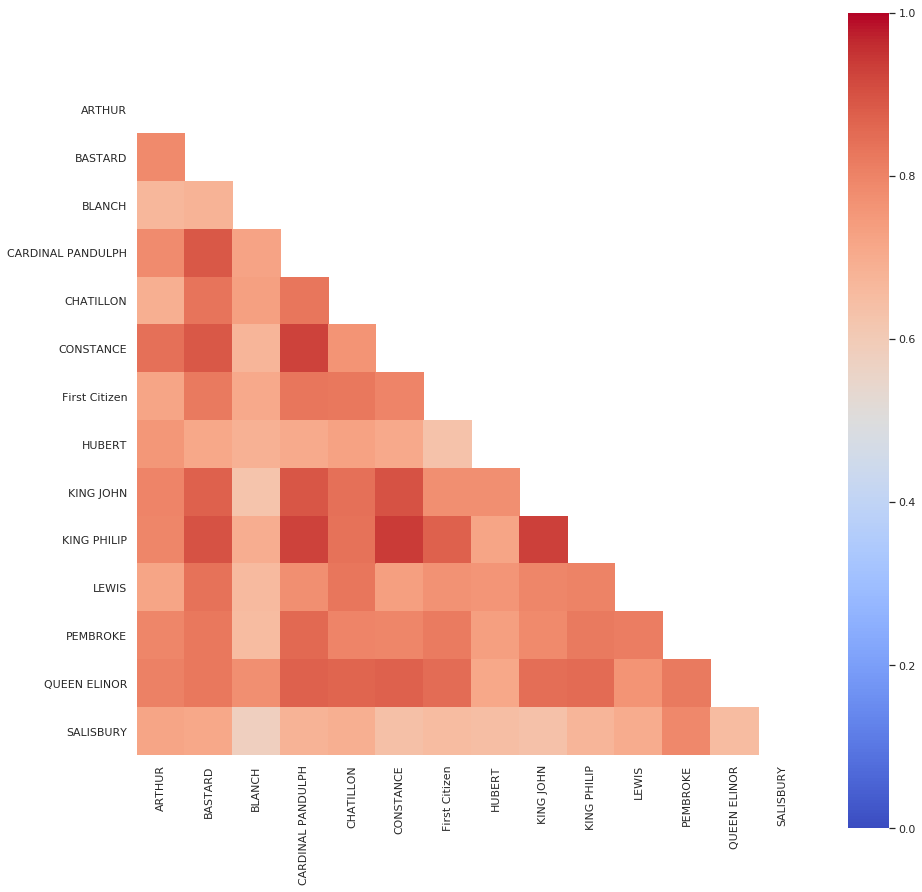

In [25]:
with open('data/The Life and Death of King John/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Life and Death of King John/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

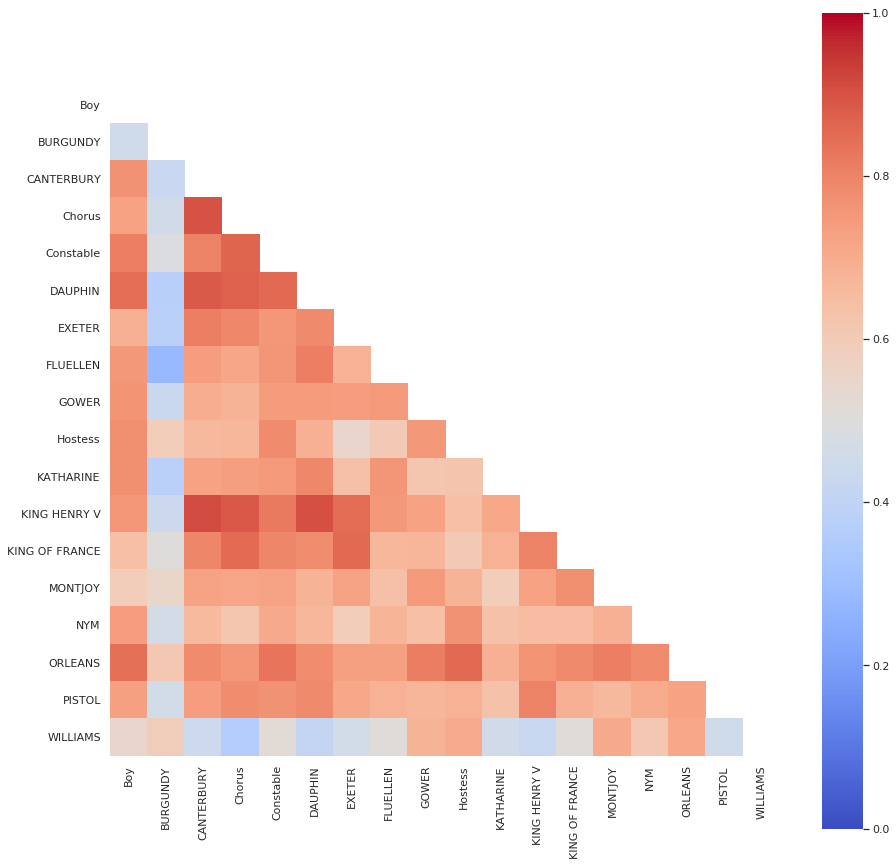

In [26]:
with open('data/The Life of Henry the Fifth/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Life of Henry the Fifth/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

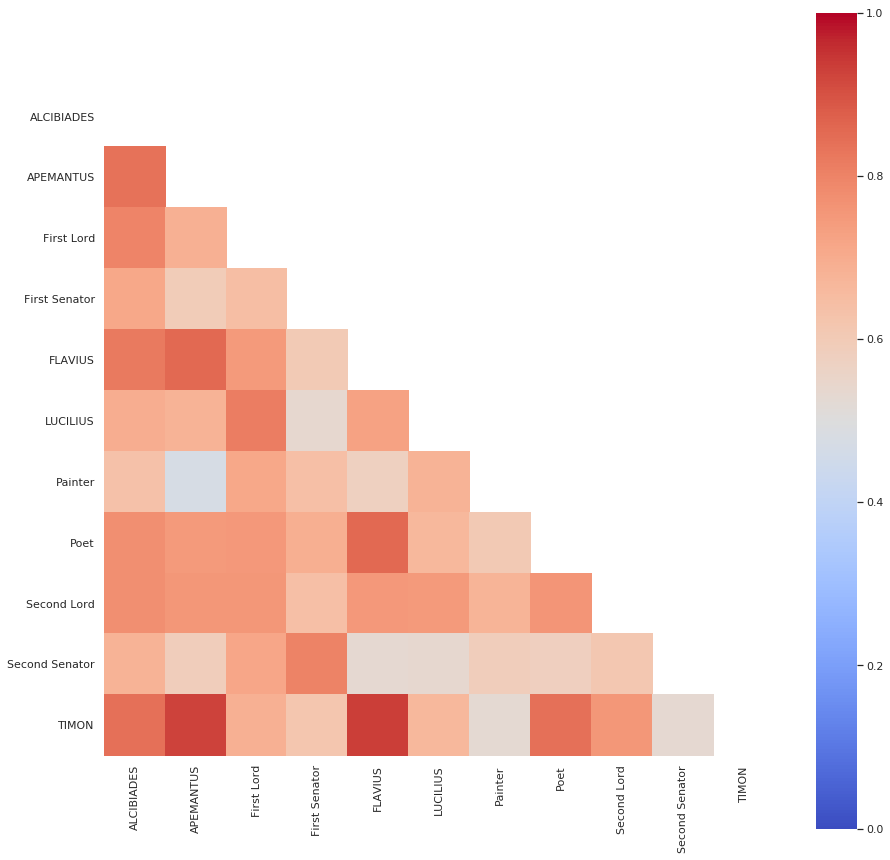

In [27]:
with open('data/The Life of Timon of Athens/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Life of Timon of Athens/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

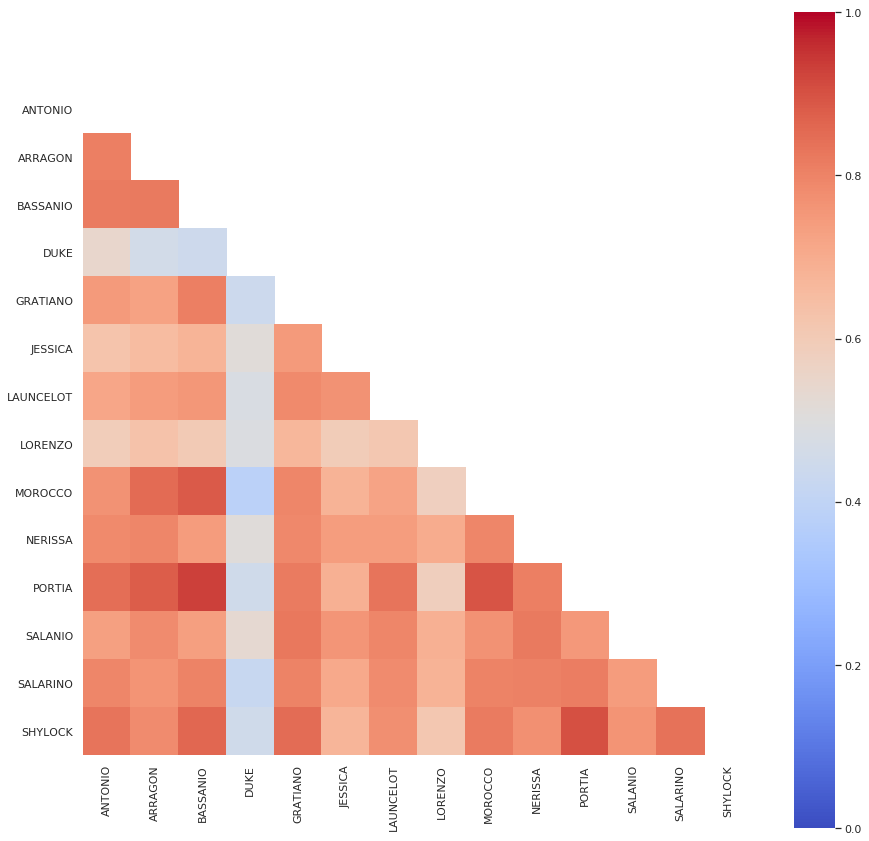

In [28]:
with open('data/The Merchant of Venice/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Merchant of Venice/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

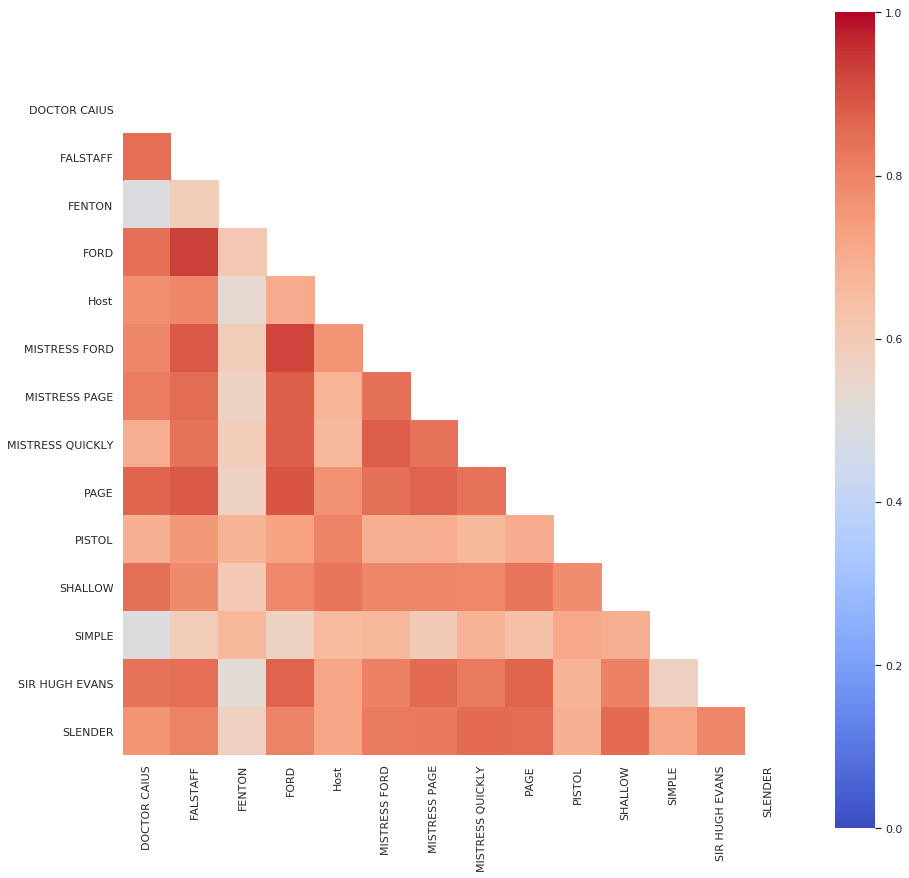

In [29]:
with open('data/The Merry Wives of Windsor/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Merry Wives of Windsor/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

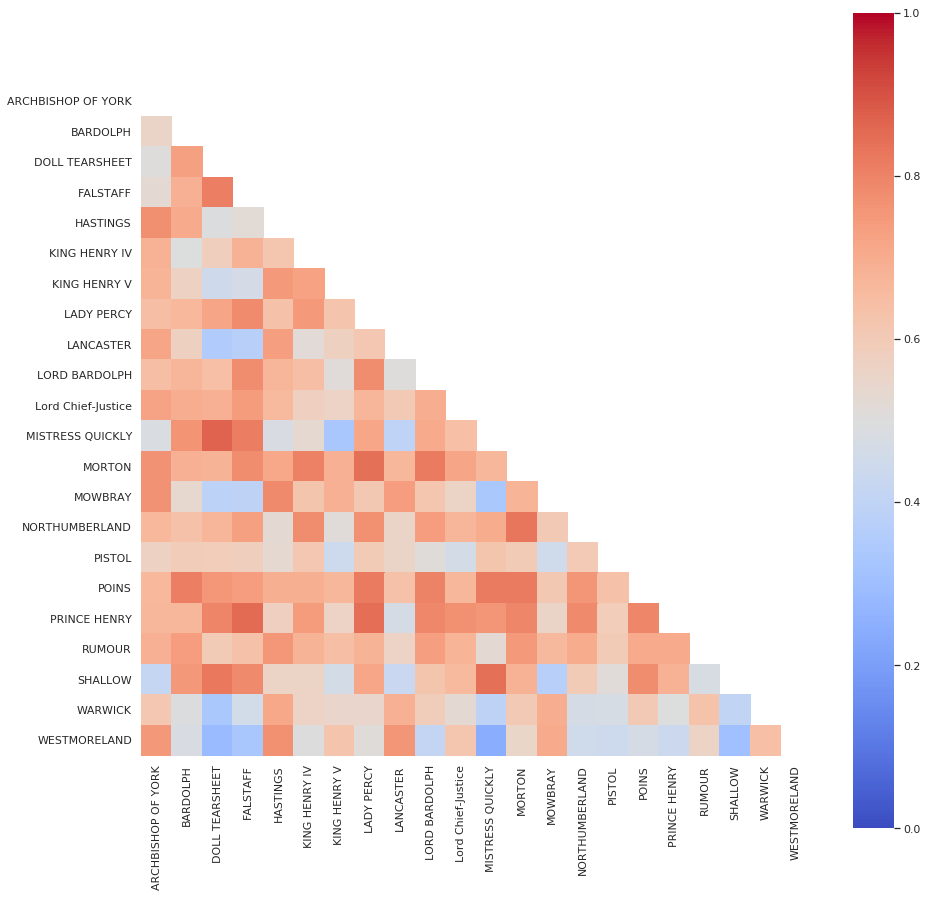

In [30]:
with open('data/The Second Part of Henry the Fourth/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Second Part of Henry the Fourth/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

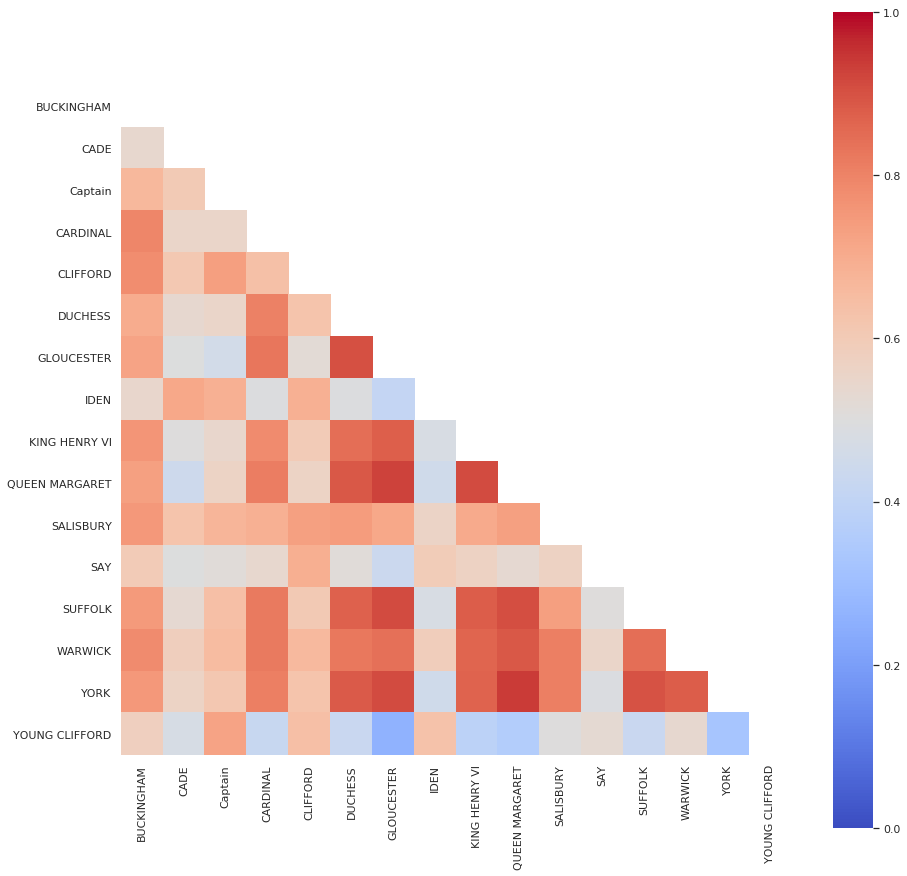

In [31]:
with open('data/The Second Part of Henry the Sixth/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Second Part of Henry the Sixth/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

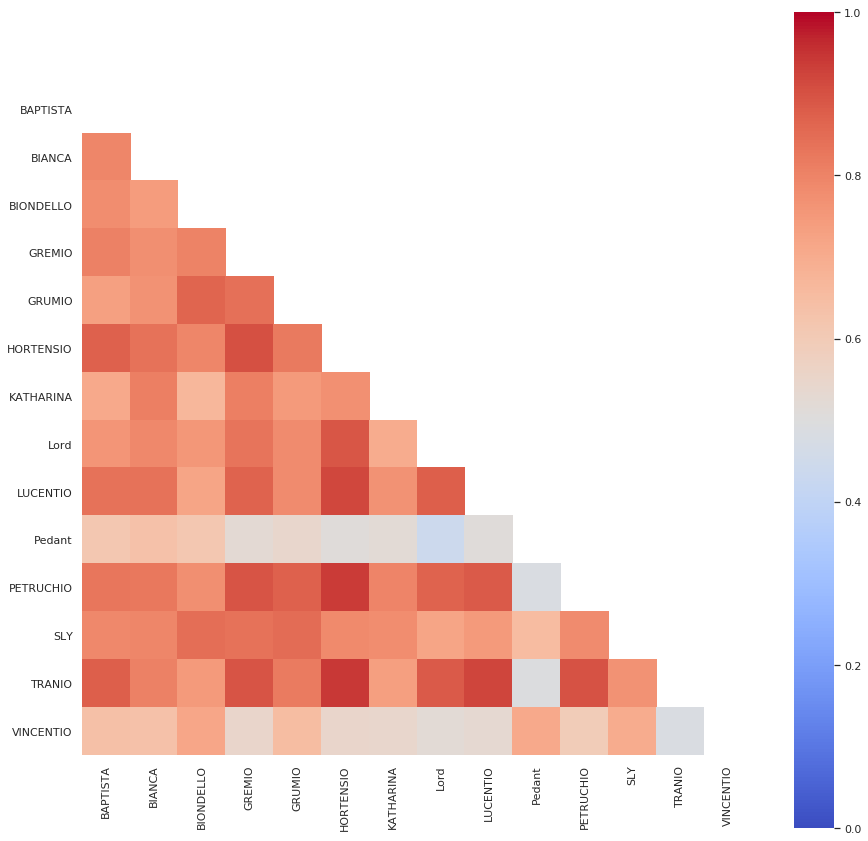

In [32]:
with open('data/The Taming of the Shrew/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Taming of the Shrew/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

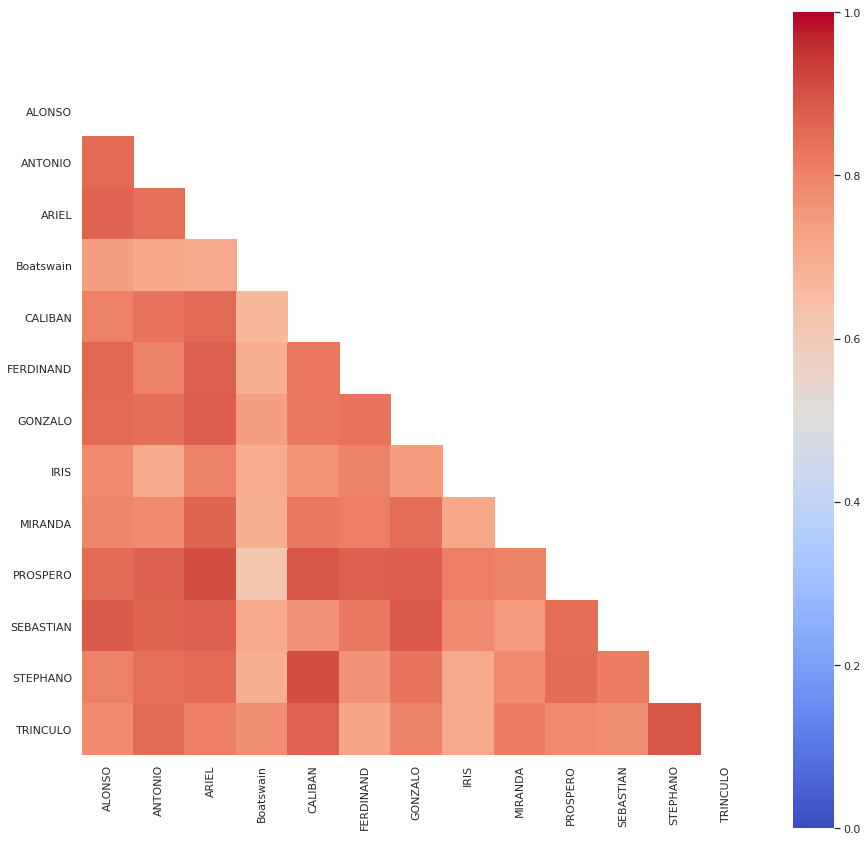

In [33]:
with open('data/The Tempest/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Tempest/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

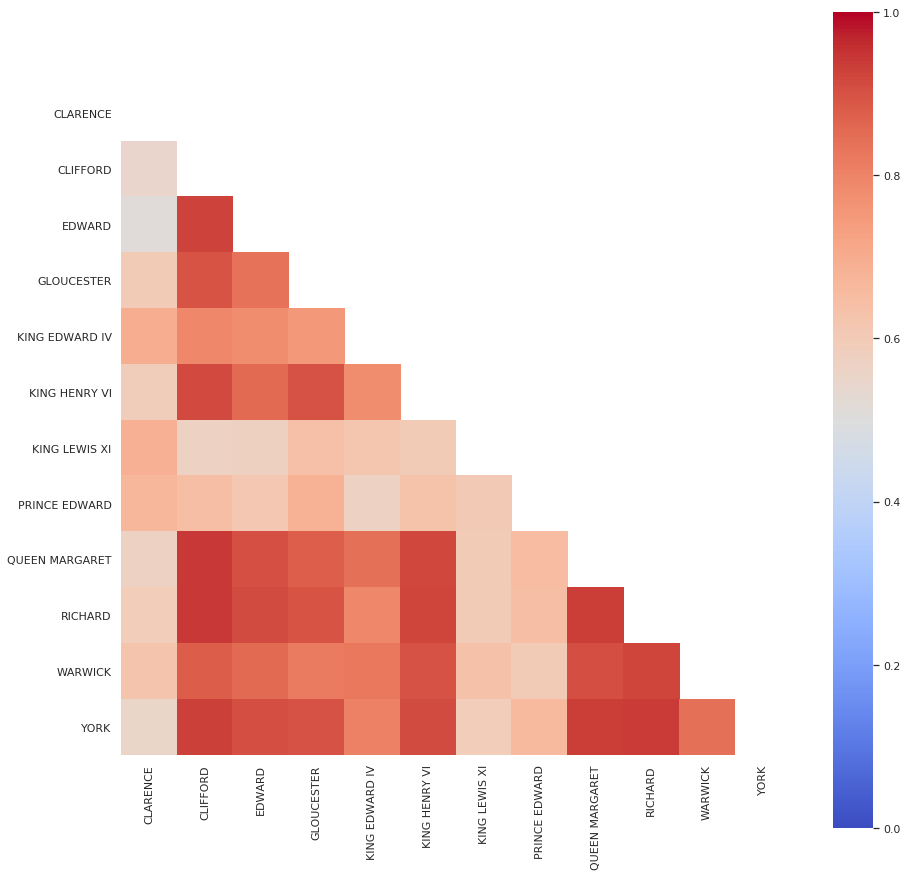

In [34]:
with open('data/The Third Part of Henry the Sixth/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Third Part of Henry the Sixth/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

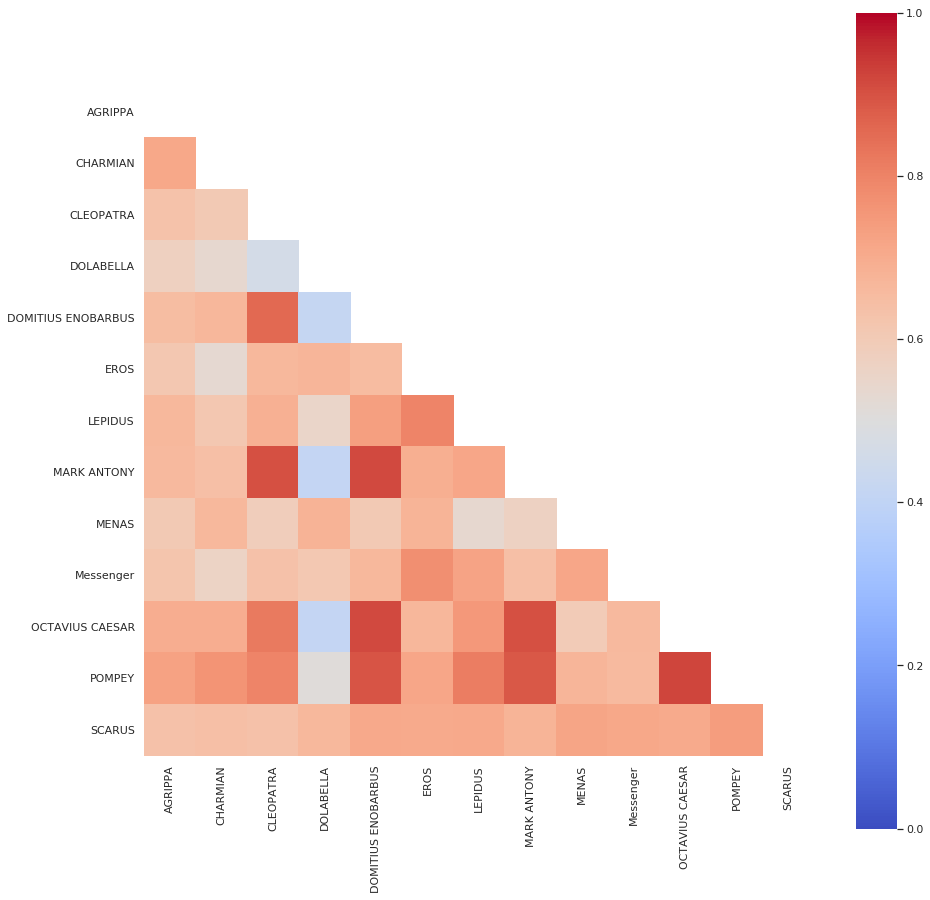

In [35]:
with open('data/The Tragedy of Antony and Cleopatra/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Tragedy of Antony and Cleopatra/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

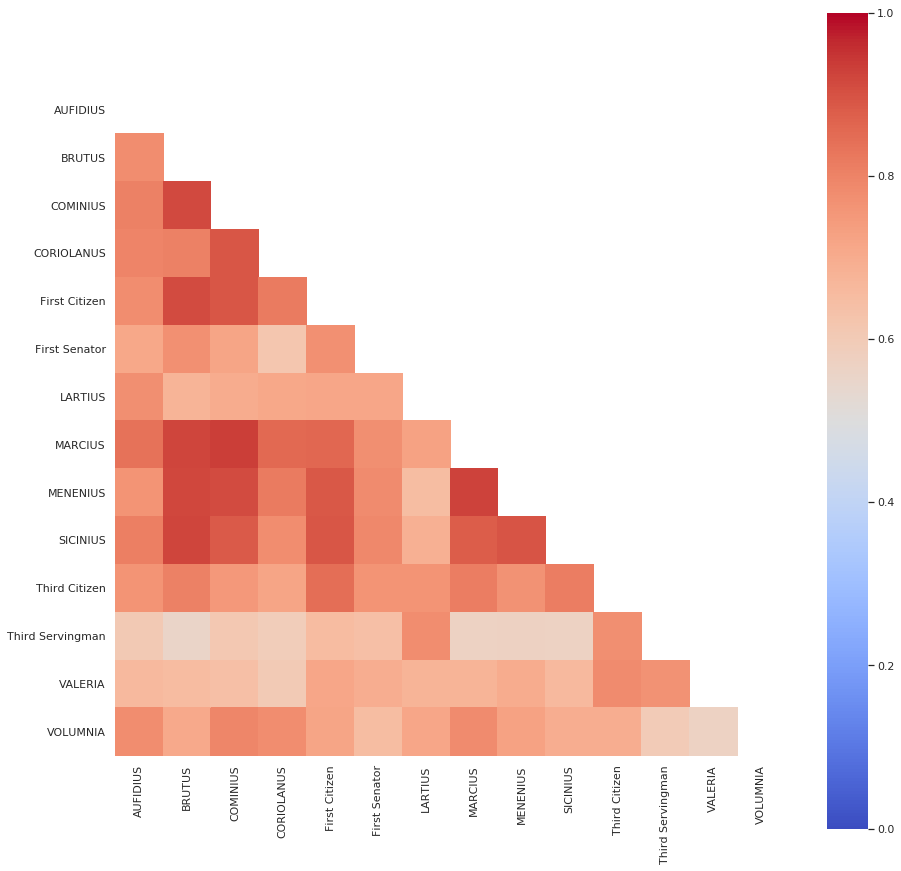

In [36]:
with open('data/The Tragedy of Coriolanus/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Tragedy of Coriolanus/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

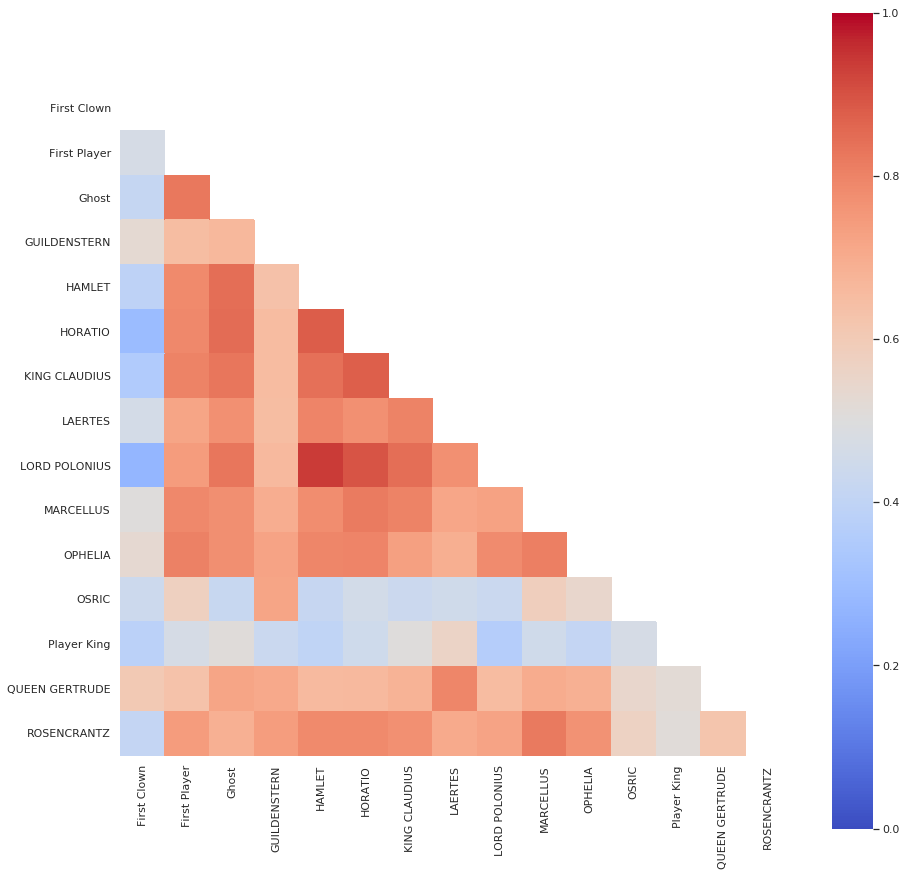

In [37]:
with open('data/The Tragedy of Hamlet, Prince of Denmark/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Tragedy of Hamlet, Prince of Denmark/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

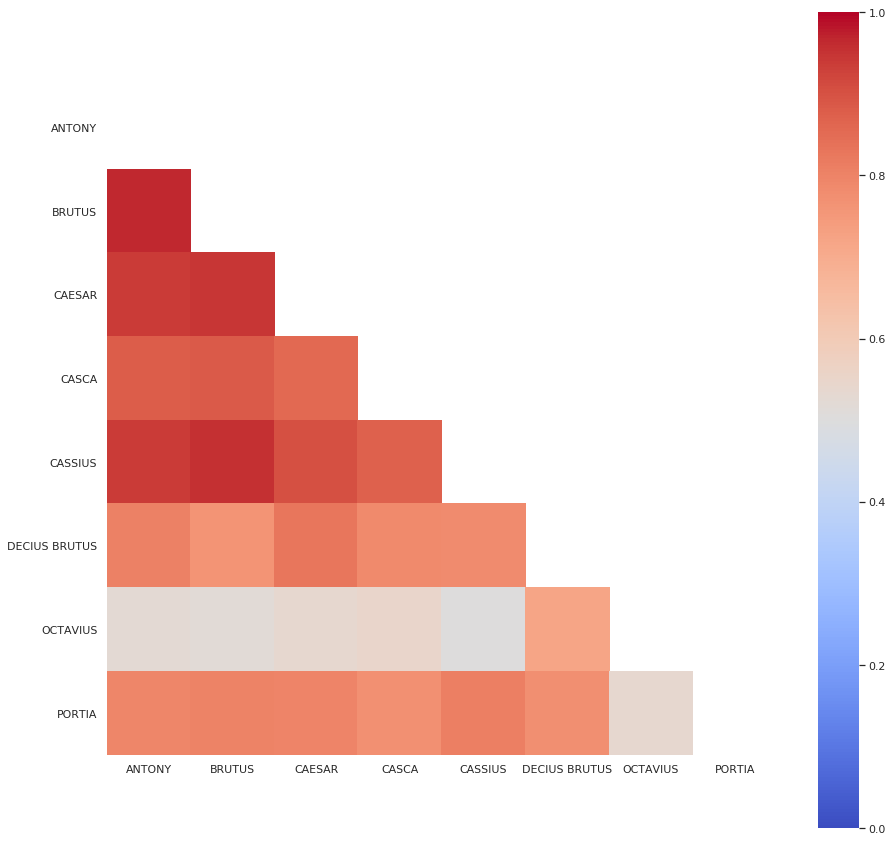

In [38]:
with open('data/The Tragedy of Julius Caesar/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Tragedy of Julius Caesar/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

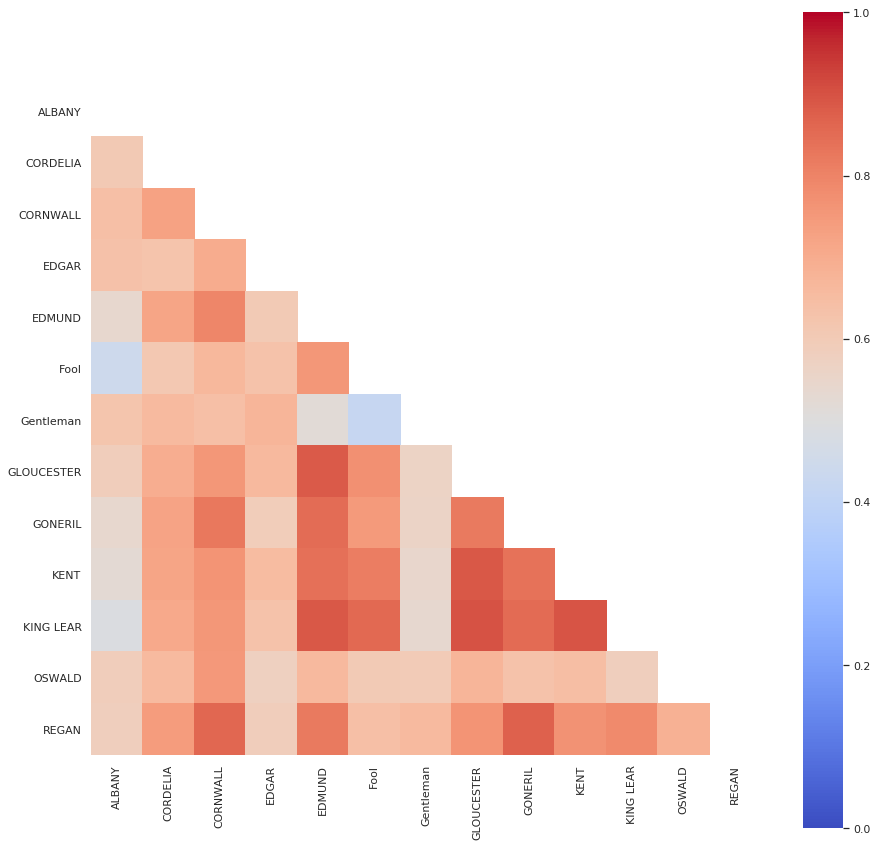

In [39]:
with open('data/The Tragedy of King Lear/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Tragedy of King Lear/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

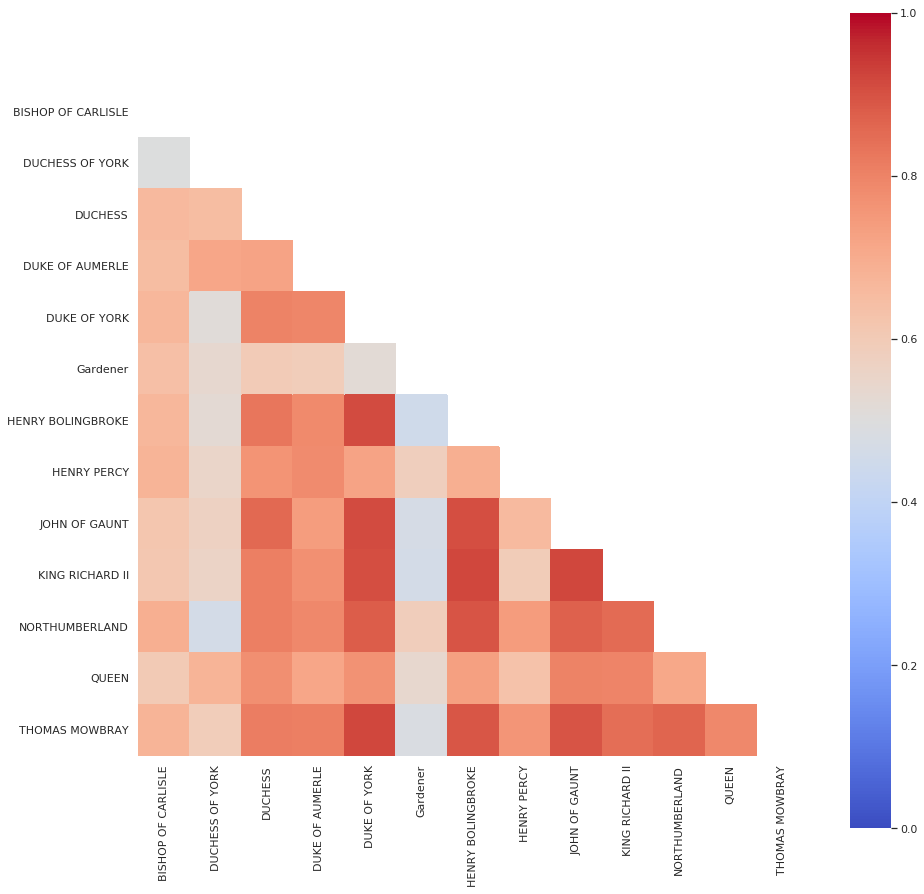

In [40]:
with open('data/The Tragedy of King Richard the Second/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Tragedy of King Richard the Second/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

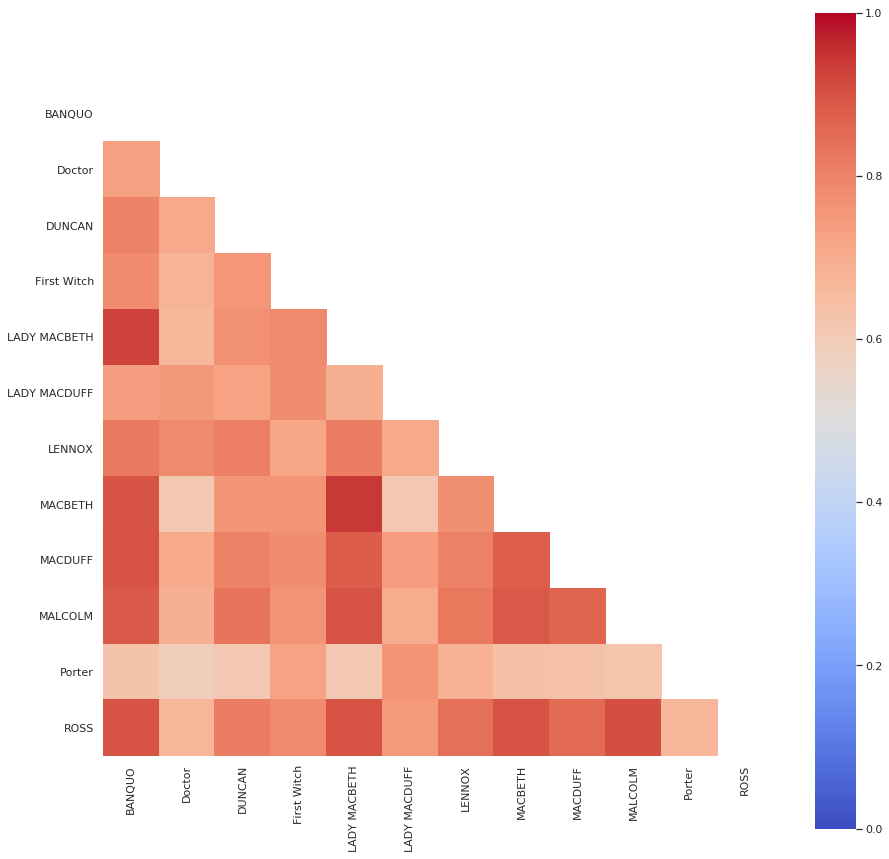

In [41]:
with open('data/The Tragedy of Macbeth/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Tragedy of Macbeth/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

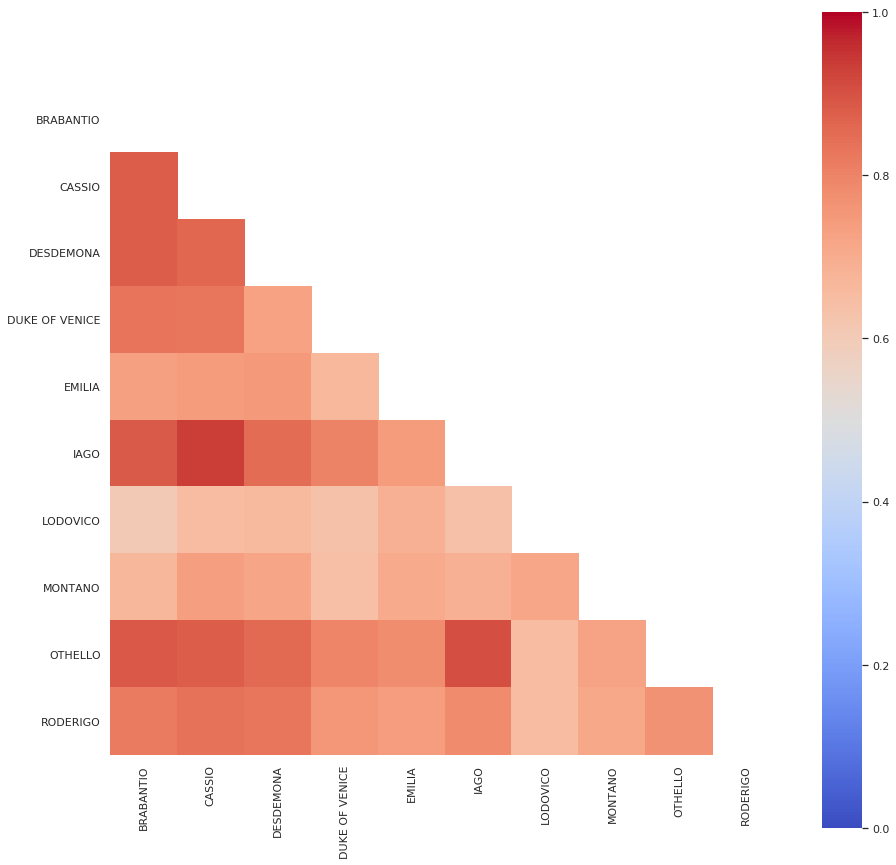

In [42]:
with open('data/The Tragedy of Othello, the Moor of Venice/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Tragedy of Othello, the Moor of Venice/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

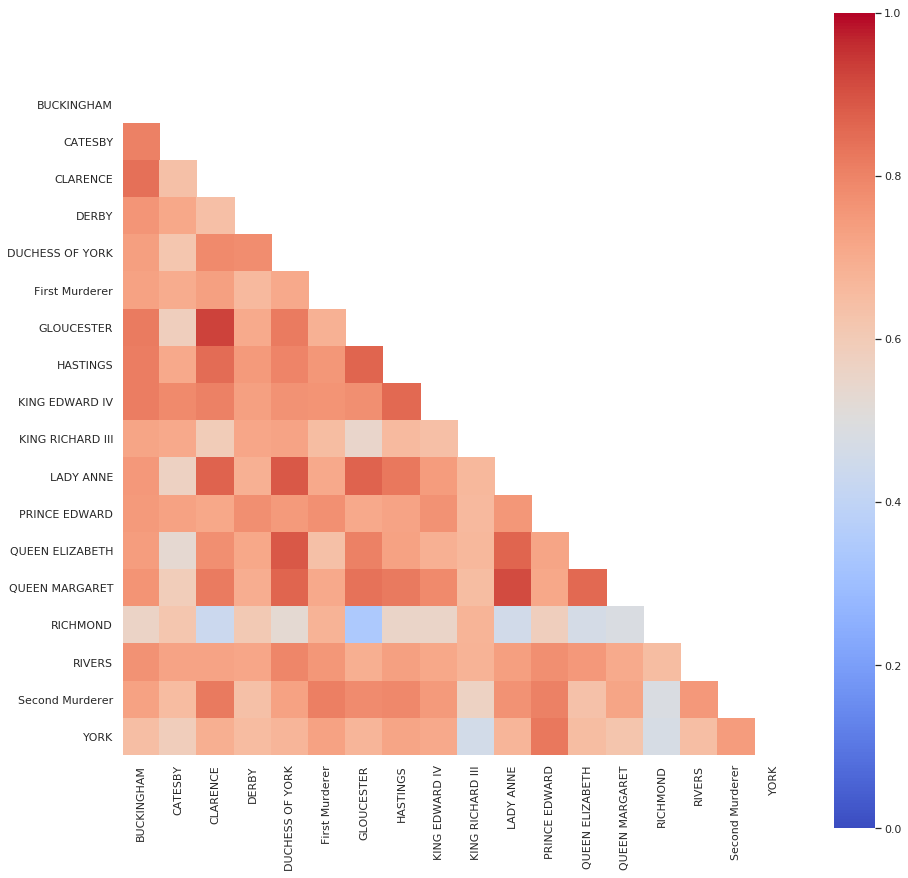

In [43]:
with open('data/The Tragedy of Richard the Third/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Tragedy of Richard the Third/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

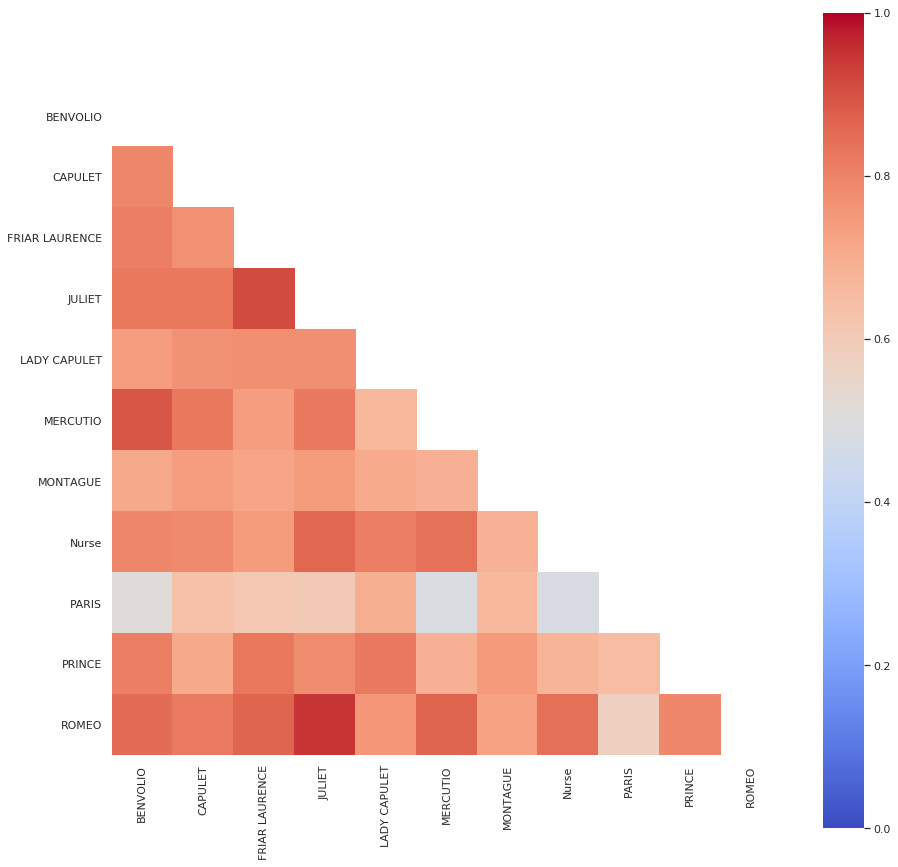

In [44]:
with open('data/The Tragedy of Romeo and Juliet/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Tragedy of Romeo and Juliet/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

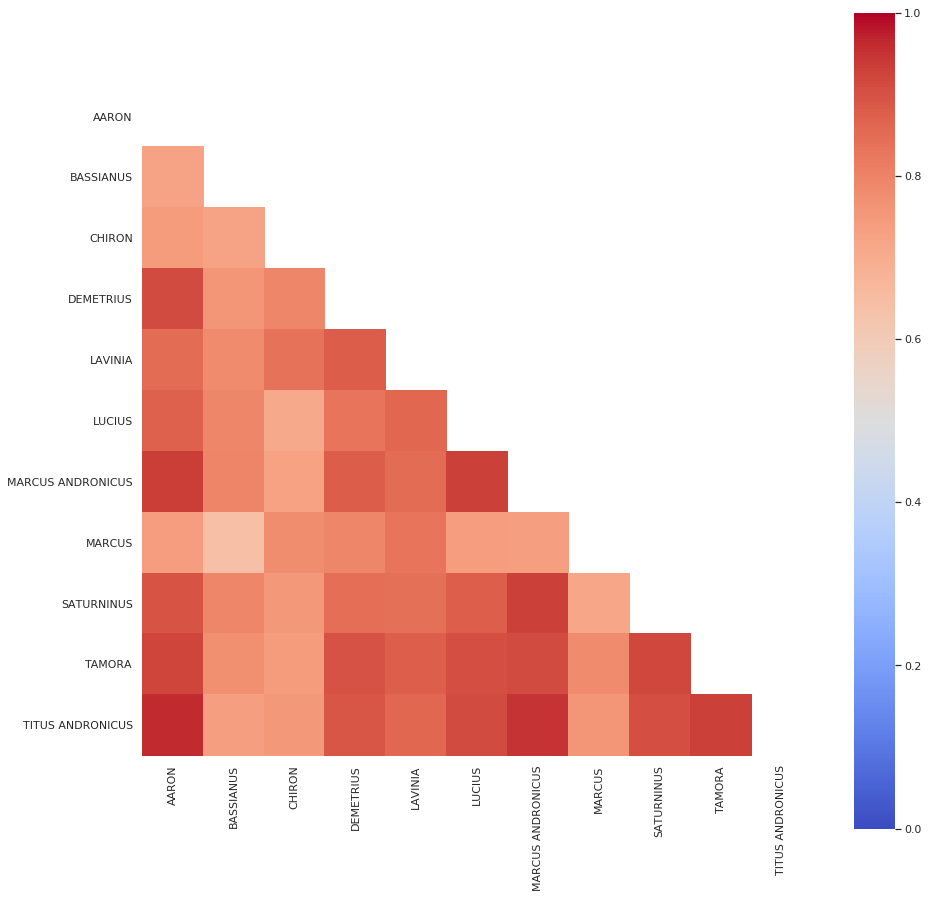

In [45]:
with open('data/The Tragedy of Titus Andronicus/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Tragedy of Titus Andronicus/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

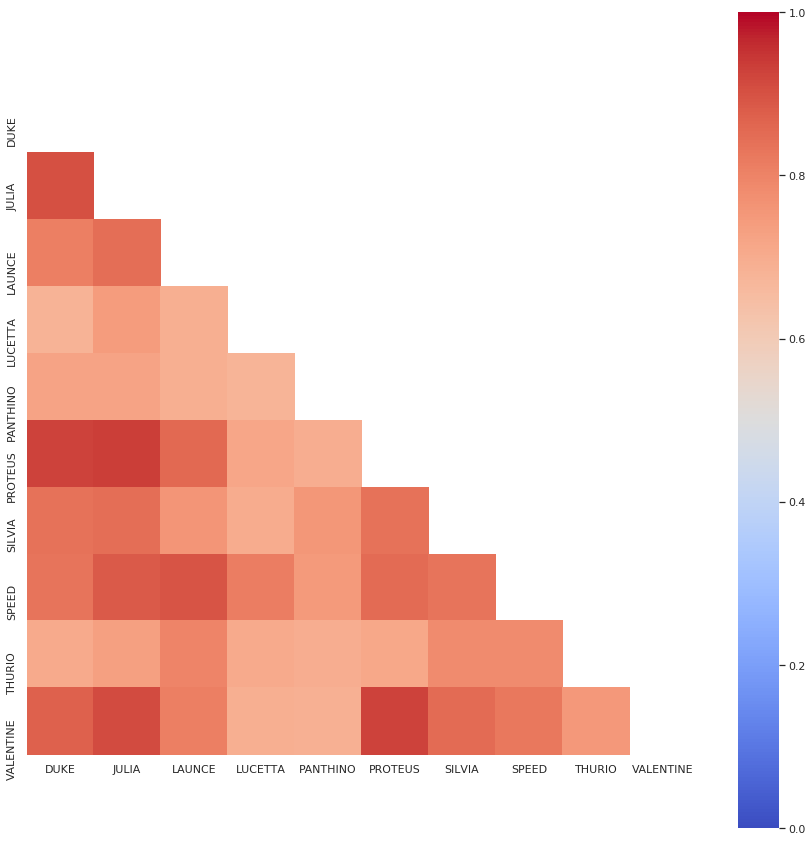

In [46]:
with open('data/The Two Gentlemen of Verona/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Two Gentlemen of Verona/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

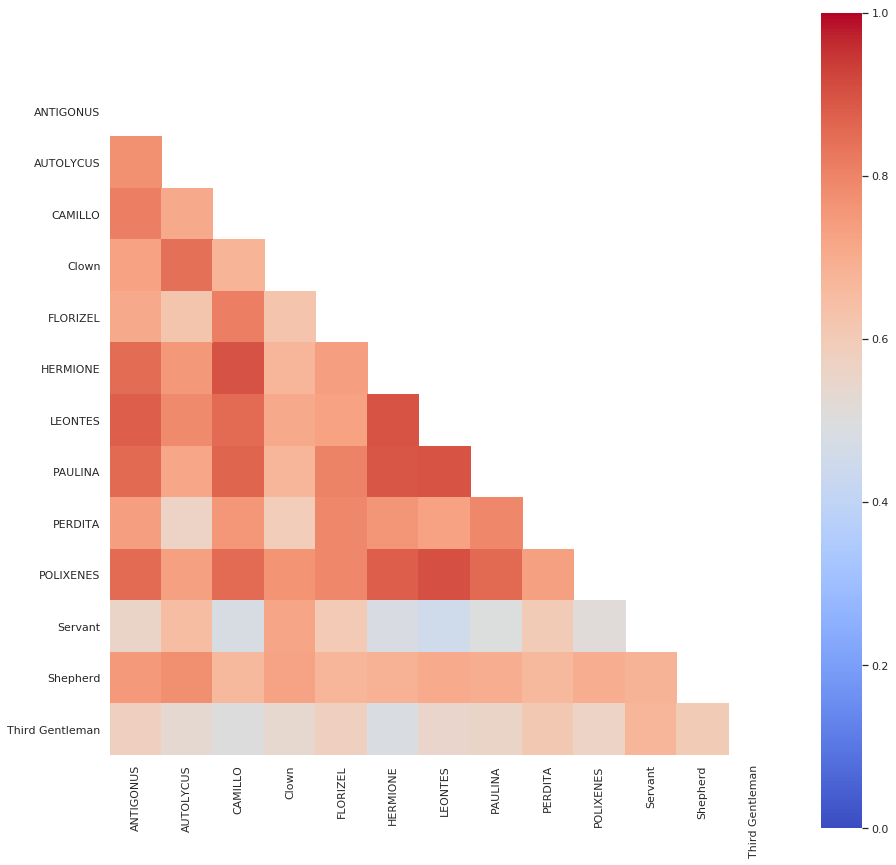

In [47]:
with open('data/The Winter\'s Tale/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/The Winter\'s Tale/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

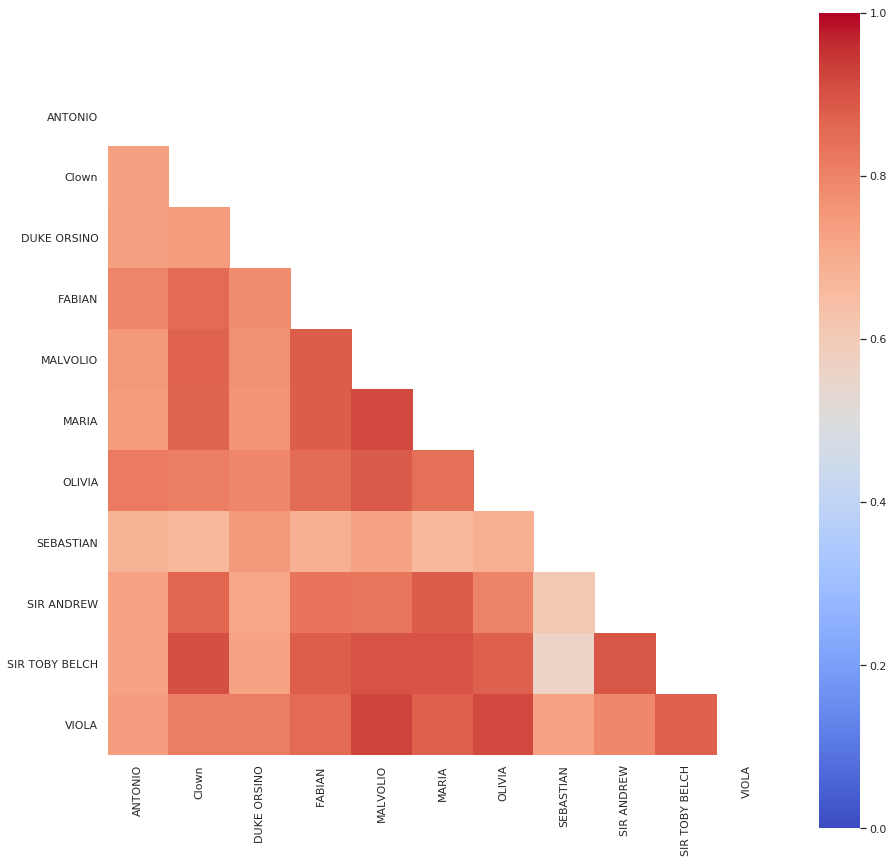

In [48]:
with open('data/Twelfth Night, or What You Will/all.log') as f:
    lines = f.readlines()

similarity_matrix = np.zeros([len(lines),len(lines)])
for i in range(len(lines)):
    for j in range(len(lines)):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

with open('data/Twelfth Night, or What You Will/chars.txt') as f:
    content = f.read().splitlines()
ann_list = [c.replace('.txt','') for c in content]
ann_list.remove("all.log")
ann_list.remove("chars") 

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
pyplot.figure(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(similarity_matrix, mask=mask, cbar = True,  square = True, xticklabels=ann_list, yticklabels=ann_list, vmin=0, vmax=1, annot_kws= {'size': 15},  cmap= 'coolwarm')

Conclusion
----------

Let's review what we've seen in this tutorial:

0. Review the relevant models: bag-of-words, Word2Vec, Doc2Vec
1. Load and preprocess the training and test corpora (see `core_concepts_corpus`)
2. Train a Doc2Vec `core_concepts_model` model using the training corpus
3. Demonstrate how the trained model can be used to infer a `core_concepts_vector`
4. Assess the model
5. Test the model on the test corpus

That's it! Doc2Vec is a great way to explore relationships between documents.

Additional Resources
--------------------

If you'd like to know more about the subject matter of this tutorial, check out the links below.

* `Word2Vec Paper <https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf>`_
* `Doc2Vec Paper <https://cs.stanford.edu/~quocle/paragraph_vector.pdf>`_
* `Dr. Michael D. Lee's Website <http://faculty.sites.uci.edu/mdlee>`_
* `Lee Corpus <http://faculty.sites.uci.edu/mdlee/similarity-data/>`__
* `IMDB Doc2Vec Tutorial <doc2vec-IMDB.ipynb>`_


